
# Regularization by Denoising (RED) for CT denoising problem.

We use as plug-in denoiser the Gradient-Step Denoiser (GSPnP) which provides an explicit prior.

Hurault, S., Leclaire, A., & Papadakis, N. 
"Gradient Step Denoiser for convergent Plug-and-Play"
In International Conference on Learning Representations.


In [1]:
import deepinv as dinv
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import RED
from deepinv.optim.optimizers import optim_builder
from deepinv.training import test
from torchvision import transforms
from deepinv.utils.parameters import get_GSPnP_params
from deepinv.utils.demo import load_dataset, load_degradation

## Setup paths for data loading and results.




In [3]:
BASE_DIR = Path(".")
ORIGINAL_DATA_DIR = BASE_DIR / "datasets"
DATA_DIR = BASE_DIR / "measurements"
RESULTS_DIR = BASE_DIR / "results"
DEG_DIR = BASE_DIR / "degradations"
# Set the global random seed from pytorch to ensure
# the reproducibility of the example.
torch.manual_seed(0)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

## Load base image datasets and degradation operators.
In this example, we use the Set3C dataset and a motion blur kernel from
[Levin et al. (2009)](https://ieeexplore.ieee.org/abstract/document/5206815/).



In [4]:
dataset_name = "set3c"
img_size = 256 if torch.cuda.is_available() else 32
operation = "super-resolution"
dataset_path = ORIGINAL_DATA_DIR / dataset_name
val_transform = transforms.Compose(
    [transforms.CenterCrop(img_size), transforms.ToTensor()]
)
dataset = load_dataset(dataset_name, ORIGINAL_DATA_DIR, transform=val_transform)

# Generate the degradation operator.
kernel_index = 1
kernel_torch = load_degradation(
    "kernels_12.npy", DEG_DIR / "kernels", index=kernel_index
)
kernel_torch = kernel_torch.unsqueeze(0).unsqueeze(
    0
)  # add batch and channel dimensions

# Use parallel dataloader if using a GPU to fasten training, otherwise, as all computes are on CPU, use synchronous dataloading.
num_workers = 4 if torch.cuda.is_available() else 0

factor = 2  # down-sampling factor
n_channels = 3  # 3 for color images, 1 for gray-scale images
n_images_max = 3  # Maximal number of images to restore from the input dataset
noise_level_img = 0.05  # Gaussian Noise standart deviation for the degradation
p = dinv.physics.Tomography(
    angles=28,
    img_width=32,
    noise_model=dinv.physics.noise.GaussianNoise(sigma = noise_level_img),
    device=device,
)



100%|██████████| 385k/385k [00:00<00:00, 6.75MiB/s]

set3c dataset downloaded in datasets


kernels_12.npy degradation downloaded in degradations\kernels


In [5]:
# Generate a dataset in a HDF5 folder in "{dir}/dinv_dataset0.h5'" and load it.
measurement_dir = DATA_DIR / dataset_name / operation
dinv_dataset_path = dinv.datasets.generate_dataset(
    train_dataset=dataset,
    test_dataset=None,
    physics=p,
    device=device,
    save_dir=measurement_dir,
    train_datapoints=n_images_max,
    num_workers=num_workers,
)
dataset = dinv.datasets.HDF5Dataset(path=dinv_dataset_path, train=True)

Dataset has been saved in measurements\set3c\super-resolution


## Setup the PnP algorithm. This involves in particular the definition of a custom prior class.
We use the proximal gradient algorithm to solve the super-resolution problem with GSPnP.



In [6]:
# Parameters of the algorithm to solve the inverse problem
early_stop = True  # Stop algorithm when convergence criteria is reached
crit_conv = "cost"  # Convergence is reached when the difference of cost function between consecutive iterates is
# smaller than thres_conv
thres_conv = 1e-5
backtracking = True
use_bicubic_init = False  # Use bicubic interpolation to initialize the algorithm
batch_size = 1  # batch size for evaluation is necessarily 1 for early stopping and backtracking to work.

# load specific parameters for GSPnP
lamb, sigma_denoiser, stepsize, max_iter = get_GSPnP_params(operation, noise_level_img)

params_algo = {
    "stepsize": stepsize,
    "g_param": sigma_denoiser,
    "lambda": lamb,
}

# Select the data fidelity term
data_fidelity = L2()


# The GSPnP prior corresponds to a RED prior with an explicit `g`.
# We thus write a class that inherits from RED for this custom prior.
class GSPnP(RED):
    r"""
    Gradient-Step Denoiser prior.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.explicit_prior = True

    def g(self, x, *args, **kwargs):
        r"""
        Computes the prior :math:`g(x)`.

        :param torch.tensor x: Variable :math:`x` at which the prior is computed.
        :return: (torch.tensor) prior :math:`g(x)`.
        """
        return self.denoiser.potential(x, *args, **kwargs)


method = "GSPnP"
denoiser_name = "gsdrunet"
# Specify the Denoising prior
prior = GSPnP(denoiser=dinv.models.GSDRUNet(pretrained="download").to(device))


# we want to output the intermediate PGD update to finish with a denoising step.
def custom_output(X):
    return X["est"][1]


# instantiate the algorithm class to solve the IP problem.
model = optim_builder(
    iteration="PGD",
    prior=prior,
    g_first=True,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=early_stop,
    max_iter=max_iter,
    crit_conv=crit_conv,
    thres_conv=thres_conv,
    backtracking=backtracking,
    get_output=custom_output,
    verbose=False,
)

# Set the model to evaluation mode. We do not require training here.
model.eval()

BaseOptim(
  (fixed_point): FixedPoint(
    (iterator): PGDIteration(
      (f_step): fStepPGD()
      (g_step): gStepPGD()
    )
  )
)

## Evaluate the model on the problem.
We evaluate the PnP algorithm on the test dataset, compute the PSNR metrics and plot reconstruction results.



Test :   0%|                                                                                                                    | 0/3 [00:00<?, ?it/s]

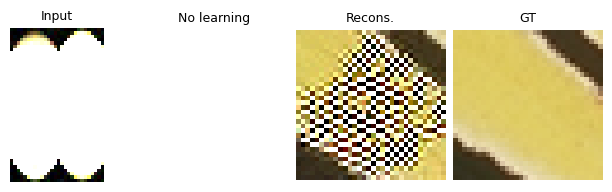

Test : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [09:16<00:00, 185.54s/it]

Test PSNR: No learning rec.: -29.306+-1.192 | Model: 17.296+-14.086. 


In [7]:
save_folder = RESULTS_DIR / method / operation / dataset_name
plot_convergence_metrics = True  # plot metrics. Metrics are saved in save_folder.
plot_images = True  # plot images. Images are saved in save_folder.

dataloader = DataLoader(
    dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)
with torch.no_grad():
    test(
        model=model,
        test_dataloader=dataloader,
        physics=p,
        device=device,
        plot_images=plot_images,
        save_folder=RESULTS_DIR / method / operation / dataset_name,
        plot_convergence_metrics=plot_convergence_metrics,
        verbose=True,
    )